In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dgr_bert_model import *
from dgr_vae_model import *
from dgr_utils import *
from dgr_linear_classifier import *
from dgr_training import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [4]:
bert_lstm = torch.load('data/model_bert_854.pth')

feature_extractor = torch.load('data/feature_extractor.pth')
feature_classifier = torch.load('data/feature_classifier.pth')

vae = torch.load('data/vae.pth')

In [5]:
train_features_sample = torch.load('data/train_features_sample.pt')
train_features_label = torch.load('data/train_features_label.pt')

val_features_sample = torch.load('data/val_features_sample.pt')
val_features_label = torch.load('data/val_features_label.pt')

In [6]:
"""
Load and process dataset from external context
"""

'\nLoad and process dataset from external context\n'

In [7]:
# dataset from external context
train_external_dataset_path = "data/PMC_train.jsonl"
test_external_dataset_path = "data/PMC_test.jsonl"

label_to_index = {
    "background": 0,
    "method": 1,
    "result": 2
}

sample_column_name = "string"
columns_to_keep = ['string', 'label']

# Load dataset
df_train = load_dataset_raw(train_external_dataset_path, sample_column=sample_column_name,
                            columns_to_keep=columns_to_keep)
df_test = load_dataset_raw(test_external_dataset_path, sample_column=sample_column_name,
                           columns_to_keep=columns_to_keep)

unique_labels = df_train['label'].unique()

In [8]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
# processing the dataset
print("Processing train external dataset...")
texts_train, labels_train = process_data_bert(df_train, label_to_index)

print("Processing test external dataset...")
texts_test, labels_test = process_data_bert(df_test, label_to_index)

print('Total number of training samples: {}'.format(len(texts_train)))
print('Total number of test samples: {}'.format(len(texts_test)))

Processing train external dataset...


100%|██████████| 3412/3412 [00:00<00:00, 18343.91it/s]


Processing test external dataset...


100%|██████████| 863/863 [00:00<00:00, 17612.75it/s]

Total number of training samples: 3412
Total number of test samples: 863


In [10]:
max_seq_length = 128

tokens_train = bert_tokenizer.batch_encode_plus(
    texts_train,
    max_length=max_seq_length,
    padding=True,
    truncation=True
)

tokens_test = bert_tokenizer.batch_encode_plus(
    texts_test,
    max_length=max_seq_length,
    padding=True,
    truncation=True
)

In [11]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(labels_train)

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(labels_test)

In [12]:
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(test_seq, test_mask, test_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [13]:
train_external_features_sample = torch.tensor([]).to(device)
train_external_features_label = torch.tensor([]).to(device)

with tqdm(total=len(train_dataloader)) as progress_bar:
    for sent_id, mask, labels in train_dataloader:
        batch_size, seq_len = sent_id.shape[0], sent_id.shape[1]

        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)

        hidden = feature_extractor.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))

        x = feature_extractor(sent_id, mask, hidden)

        train_external_features_sample = torch.cat((train_external_features_sample, x), dim=0)
        train_external_features_label = torch.cat((train_external_features_label, labels), dim=0)

        progress_bar.update(1)

train_external_features_label = train_external_features_label.long()

100%|██████████| 107/107 [00:33<00:00,  3.17it/s]


In [14]:
print(train_external_features_sample.shape)
print(train_external_features_label.shape)

torch.Size([3412, 1024])
torch.Size([3412])


In [15]:
external_label_counts = torch.bincount(train_external_features_label)
print(external_label_counts)

tensor([2241,  718,  453], device='cuda:0')


In [16]:
val_external_features_sample = torch.tensor([]).to(device)
val_external_features_label = torch.tensor([]).to(device)

with tqdm(total=len(val_dataloader)) as progress_bar:
    for sent_id, mask, labels in val_dataloader:
        batch_size, seq_len = sent_id.shape[0], sent_id.shape[1]

        sent_id, mask, labels = sent_id.to(device), mask.to(device), labels.to(device)

        hidden = feature_extractor.init_hidden(batch_size)
        hidden = (hidden[0].to(device), hidden[1].to(device))

        x = feature_extractor(sent_id, mask, hidden)

        val_external_features_sample = torch.cat((val_external_features_sample, x), dim=0)
        val_external_features_label = torch.cat((val_external_features_label, labels), dim=0)

        progress_bar.update(1)

val_external_features_label = val_external_features_label.long()

100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


In [17]:
print(val_external_features_sample.shape)
print(val_external_features_label.shape)

torch.Size([863, 1024])
torch.Size([863])


In [18]:
batch_size = 32

In [19]:
# dataloaders for external dataset
external_train_dataset = TensorDataset(train_external_features_sample, train_external_features_label)
external_train_dataset_sampler = RandomSampler(external_train_dataset)
external_train_dataloader = DataLoader(external_train_dataset,
                                       sampler=external_train_dataset_sampler,
                                       batch_size=batch_size)

external_val_dataset = TensorDataset(val_external_features_sample, val_external_features_label)
external_val_dataset_sampler = RandomSampler(external_val_dataset)
external_val_dataloader = DataLoader(external_val_dataset,
                                     sampler=external_val_dataset_sampler,
                                     batch_size=batch_size)

In [20]:
# dataloaders for original dataset
train_features_dataset = TensorDataset(train_features_sample, train_features_label)
train_features_sampler = RandomSampler(train_features_dataset)
train_features_dataloader = DataLoader(train_features_dataset,
                                       sampler=train_features_sampler,
                                       batch_size=batch_size)

val_features_dataset = TensorDataset(val_features_sample, val_features_label)
val_features_sampler = RandomSampler(val_features_dataset)
val_features_dataloader = DataLoader(val_features_dataset,
                                     sampler=val_features_sampler,
                                     batch_size=batch_size)

In [21]:
"""
Show catastrophic forgetting

-> train using external dataset
-> validate using original dataset

training score (external context) should increase
validation score (original context) should decrease
"""

'\nShow catastrophic forgetting\n\n-> train using external dataset\n-> validate using original dataset\n\ntraining score (external context) should increase\nvalidation score (original context) should decrease\n'

In [22]:
feature_classifier_retrain = torch.load('data/feature_classifier.pth')

In [23]:
class_weights = torch.tensor([1 / external_label_counts[0].item(),
                              1 / external_label_counts[1].item(),
                              1 / external_label_counts[2].item()]).to(device)

# define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(feature_classifier_retrain.parameters(), lr=0.0001)

In [24]:
f1_score_c1 = evaluate_dgr(feature_classifier_retrain, val_features_dataloader, device)
print("F1 score on Context 1: {:.3}".format(f1_score_c1))

f1_score_c2 = evaluate_dgr(feature_classifier_retrain, external_val_dataloader, device)
print("F1 score on Context 2: {:.3}".format(f1_score_c2))

F1 score on Context 1: 0.854
F1 score on Context 2: 0.469


In [25]:
num_epochs = 100

results1 = train_dgr(feature_classifier_retrain,
                    external_train_dataloader,
                    val_features_dataloader,
                    external_val_dataloader,
                    optimizer, criterion, num_epochs, device,
                    verbose=True)

Total Training Time (total number of epochs: 100)
saving model checkpoint to data/linear_model.pth
[Epoch 1] loss:	119.019, f1 train: 0.489, f1 test c1: 0.819, f1 test c2: 0.472 
saving model checkpoint to data/linear_model.pth
[Epoch 2] loss:	109.899, f1 train: 0.503, f1 test c1: 0.779, f1 test c2: 0.489 
[Epoch 3] loss:	110.232, f1 train: 0.520, f1 test c1: 0.774, f1 test c2: 0.489 
saving model checkpoint to data/linear_model.pth
[Epoch 4] loss:	109.286, f1 train: 0.539, f1 test c1: 0.754, f1 test c2: 0.490 
saving model checkpoint to data/linear_model.pth
[Epoch 5] loss:	108.197, f1 train: 0.546, f1 test c1: 0.738, f1 test c2: 0.495 
saving model checkpoint to data/linear_model.pth
[Epoch 6] loss:	107.352, f1 train: 0.551, f1 test c1: 0.736, f1 test c2: 0.508 
[Epoch 7] loss:	107.930, f1 train: 0.553, f1 test c1: 0.726, f1 test c2: 0.505 
[Epoch 8] loss:	108.106, f1 train: 0.551, f1 test c1: 0.715, f1 test c2: 0.505 
saving model checkpoint to data/linear_model.pth
[Epoch 9] loss:	

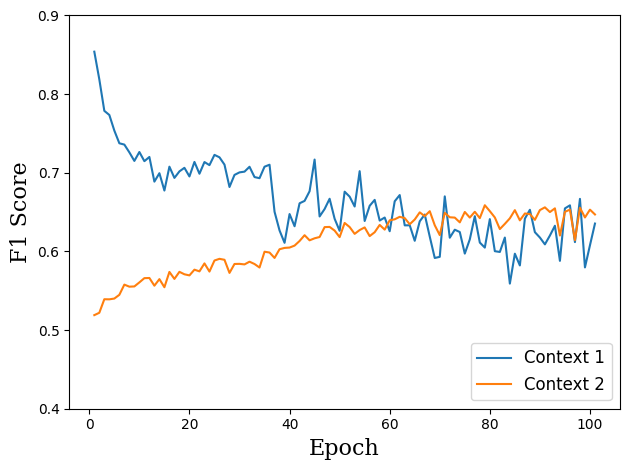

In [57]:
"""
When training the trained model on external dataset, validation score should start to drop
"""
plot_training_results_dgr(results1)

1.3141996648380092


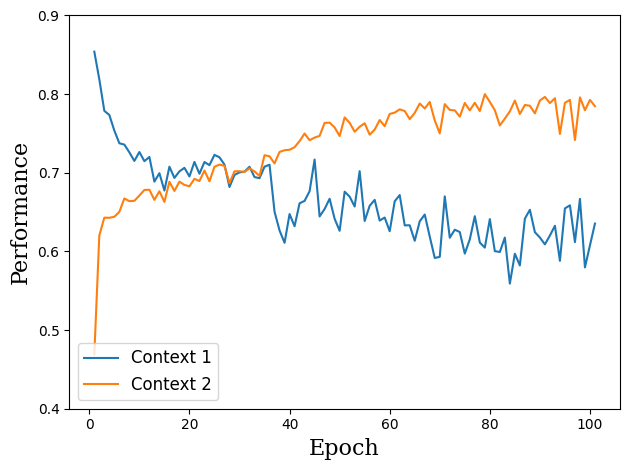

In [27]:
plot_training_results_dgr(results1, c1=False, c2=True)

Evaluating model: data/linear_model.pth
F1 score for model: 0.609


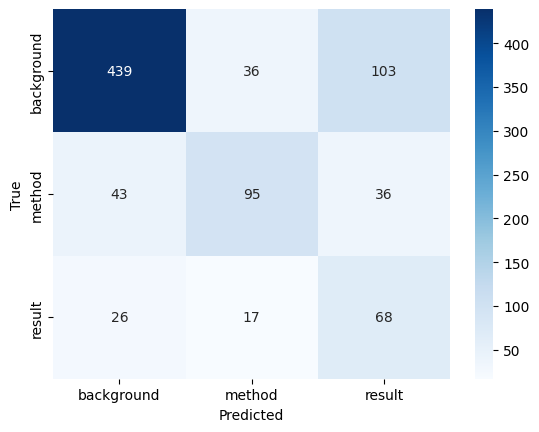

              precision    recall  f1-score   support

  background       0.86      0.76      0.81       578
      method       0.64      0.55      0.59       174
      result       0.33      0.61      0.43       111

    accuracy                           0.70       863
   macro avg       0.61      0.64      0.61       863
weighted avg       0.75      0.70      0.72       863


In [28]:
model_path = 'data/linear_model.pth'

eval_model = torch.load(model_path)

y_true, y_pred = evaluate_dgr(eval_model, external_val_dataloader, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)

In [29]:
"""
Deep Generative Replay

-> generate features with the VAE model
-> generate labels with the FeatureClassifier
"""

'\nDeep Generative Replay\n\n-> generate features with the VAE model\n-> generate labels with the FeatureClassifier\n'

In [30]:
def generate_samples(vae, num_samples):
    vae.eval()

    # Generate samples
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, vae.latent_dim).to(device)
        generated_samples = vae.decoder(latent_samples)

    return generated_samples

In [31]:
generated_data_ratio = 1.0

num_samples = int(math.floor(generated_data_ratio * len(train_external_features_sample)))

generated_samples = generate_samples(vae, num_samples)
print(generated_samples.shape)

torch.Size([3412, 1024])


In [32]:
pred = feature_classifier(generated_samples)
generated_labels = torch.argmax(pred, dim=1)
print(generated_labels.shape)

torch.Size([3412])


In [33]:
generated_label_counts = torch.bincount(generated_labels)
print(generated_label_counts)

tensor([1828, 1170,  414], device='cuda:0')


In [34]:
combined_features = torch.cat((train_external_features_sample, generated_samples), dim=0)
combined_labels = torch.cat((train_external_features_label, generated_labels), dim=0)

In [35]:
batch_size = 32

combined_dataset = TensorDataset(combined_features, combined_labels)
combined_dataset_sampler = RandomSampler(combined_dataset)
combined_train_dataloader = DataLoader(combined_dataset,
                                       sampler=combined_dataset_sampler,
                                       batch_size=batch_size)

In [36]:
combined_counts = external_label_counts + generated_label_counts
print(combined_counts)

tensor([4069, 1888,  867], device='cuda:0')


In [37]:
feature_classifier_dgr = torch.load('data/feature_classifier.pth')

In [38]:
class_weights = torch.tensor([1 / combined_counts[0].item(),
                              1 / combined_counts[1].item(),
                              1 / combined_counts[2].item()]).to(device)

# define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(feature_classifier_dgr.parameters(), lr=0.0001)

In [39]:
f1_score_c1 = evaluate_dgr(feature_classifier_dgr, val_features_dataloader, device)
print("F1 score on Context 1: {:.3}".format(f1_score_c1))

f1_score_c2 = evaluate_dgr(feature_classifier_dgr, external_val_dataloader, device)
print("F1 score on Context 2: {:.3}".format(f1_score_c2))

F1 score on Context 1: 0.854
F1 score on Context 2: 0.469


In [40]:
num_epochs = 100

results2 = train_dgr(feature_classifier_dgr,
                    combined_train_dataloader,
                    val_features_dataloader,
                    external_val_dataloader,
                    optimizer, criterion, num_epochs, device,
                    verbose=True)

Total Training Time (total number of epochs: 100)
saving model checkpoint to data/linear_model.pth
[Epoch 1] loss:	181.212, f1 train: 0.770, f1 test c1: 0.820, f1 test c2: 0.470 
saving model checkpoint to data/linear_model.pth
[Epoch 2] loss:	170.023, f1 train: 0.777, f1 test c1: 0.842, f1 test c2: 0.474 
[Epoch 3] loss:	171.202, f1 train: 0.777, f1 test c1: 0.836, f1 test c2: 0.473 
saving model checkpoint to data/linear_model.pth
[Epoch 4] loss:	168.791, f1 train: 0.780, f1 test c1: 0.837, f1 test c2: 0.475 
saving model checkpoint to data/linear_model.pth
[Epoch 5] loss:	169.441, f1 train: 0.787, f1 test c1: 0.822, f1 test c2: 0.484 
saving model checkpoint to data/linear_model.pth
[Epoch 6] loss:	167.441, f1 train: 0.794, f1 test c1: 0.820, f1 test c2: 0.503 
saving model checkpoint to data/linear_model.pth
[Epoch 7] loss:	166.022, f1 train: 0.796, f1 test c1: 0.816, f1 test c2: 0.519 
saving model checkpoint to data/linear_model.pth
[Epoch 8] loss:	165.222, f1 train: 0.796, f1 te

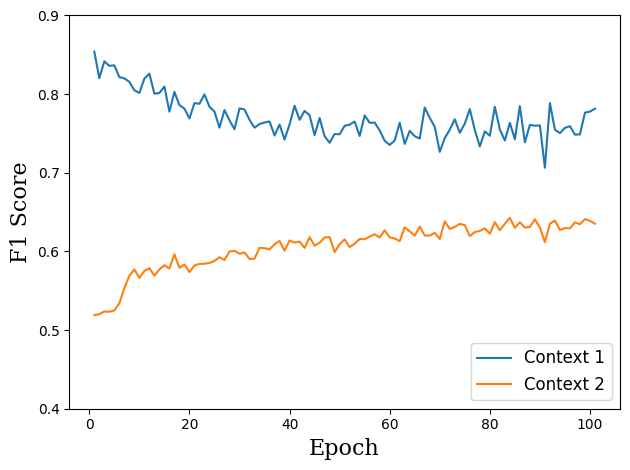

In [56]:
"""
When training the trained model on external dataset with the generated dataset, validation score should not drop much
"""
plot_training_results_dgr(results2)

1.349670055562394
0.8417926382762047


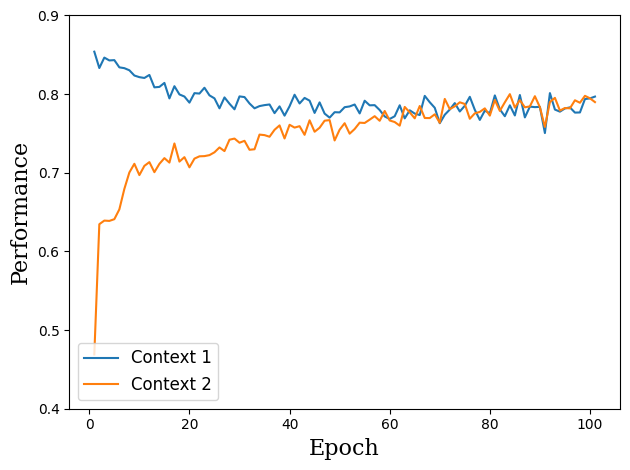

In [42]:
plot_training_results_dgr(results2, c1=True, c2=True)

Evaluating model: data/linear_model.pth
F1 score for model: 0.593


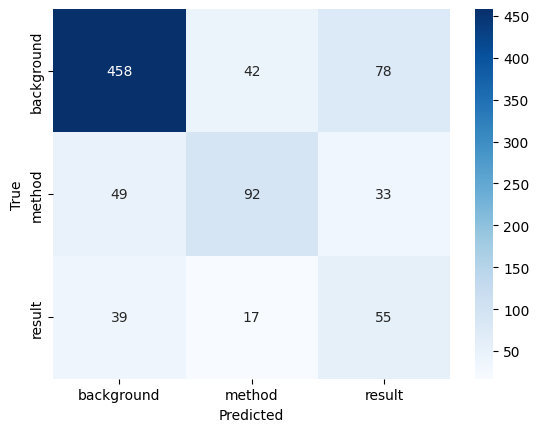

              precision    recall  f1-score   support

  background       0.84      0.79      0.81       578
      method       0.61      0.53      0.57       174
      result       0.33      0.50      0.40       111

    accuracy                           0.70       863
   macro avg       0.59      0.61      0.59       863
weighted avg       0.73      0.70      0.71       863


In [43]:
model_path = 'data/linear_model.pth'

eval_model = torch.load(model_path)

y_true, y_pred = evaluate_dgr(eval_model, external_val_dataloader, device, is_f1=False)
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true, y_pred, average='macro')
cm_eval = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=label_list)

print('Evaluating model: {}'.format(model_path))
print('F1 score for model: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)